# This notebook will run through the general fitting process for matching CO models to late-time spectra.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats
import matplotlib
from scipy.ndimage import gaussian_filter1d
import os

import get_model

In [2]:
path = os.getcwd()
co_path = '/'.join(path.split('/')[:-1])+'/'
plot = 0
coplus = 0

In [3]:
redshift  = 0.002
spec = 'SN2013ej_20131214_fire.dat'
specPhase = '143.8'

# This is all just reading the spectrum to fit

In [4]:
spec=pd.read_csv(spec,delimiter='\s+',header=None)
    
if spec.shape[1] == 2:
    spec.columns = ['lambda','flux']  
if spec.shape[1] == 3:   
    spec.columns = ['lambda','flux','err']
if spec['lambda'].values[10] > 1000:
    spec['lambda'] = spec['lambda']/1e4
spec['lambda'] = spec['lambda']/(1+redshift)
spec = spec[(spec['lambda']>2.2)]

# data scaling
upper, lower = 2.20, 2.25
if coplus: upper, lower = 2.20, 2.25
w = np.argmin(abs(np.array(spec['lambda'])-upper))
v = np.argmin(abs(np.array(spec['lambda'])-lower))
integ0 = np.trapz(spec['flux'][w:v],spec['lambda'][w:v])
off = 0.05/integ0
q = [(spec['lambda'] >= 2.25) & (spec['lambda'] <= 2.3)][0]
spec['flux'] = np.array(spec['flux'])*off
spec['flux'] = spec['flux'] - np.min(spec['flux'][q])

# For speed within this Python script we want to use dataframes and csv files. We can use the raw model output files but they are about 10 times slower to read.

In [7]:
df = pd.read_csv(co_path+'Hoeflich_models.csv')

# Limiting to only the models that we care about for this example, i.e. what will fit reasonably well.
df = df[(df.molecule == 'CO')]
df = df[(df.mole_frac==0.0)&(df.temperature==3000.)] 
df

,filename,dataset,mole_frac,temperature,n,velocity,molecule
12,plot.dat_1000_3_0.0_CO,3,0.0,3000.0,1.000000e+07,1000,CO
13,plot.dat_1000_3_0.0_CO,3,0.0,3000.0,1.000000e+08,1000,CO
14,plot.dat_1000_3_0.0_CO,3,0.0,3000.0,1.000000e+09,1000,CO
15,plot.dat_1000_3_0.0_CO,3,0.0,3000.0,1.000000e+11,1000,CO
76,plot.dat_1000_4_0.0_CO,4,0.0,3000.0,1.000000e+07,1000,CO
...,...,...,...,...,...,...,...
2543,plot.dat_5500_4_0.0_CO,4,0.0,3000.0,1.000000e+11,5500,CO
2572,plot.dat_750_4_0.0_CO,4,0.0,3000.0,1.000000e+07,750,CO
2573,plot.dat_750_4_0.0_CO,4,0.0,3000.0,1.000000e+08,750,CO
2574,plot.dat_750_4_0.0_CO,4,0.0,3000.0,1.000000e+09,750,CO


0.6521079295981318


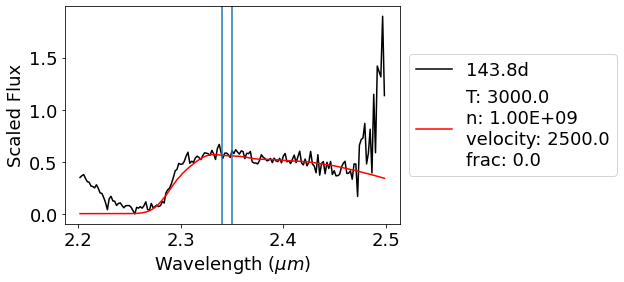

0.6521079295981318


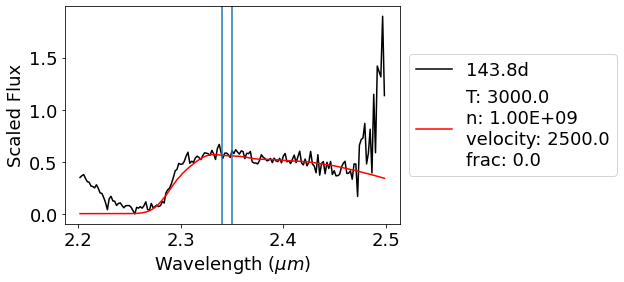

0.65213685486708


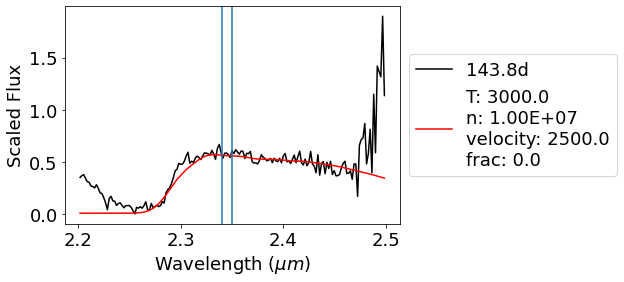

0.65213685486708


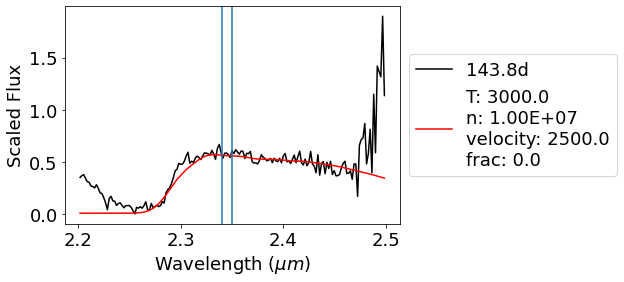

0.6525126055373685


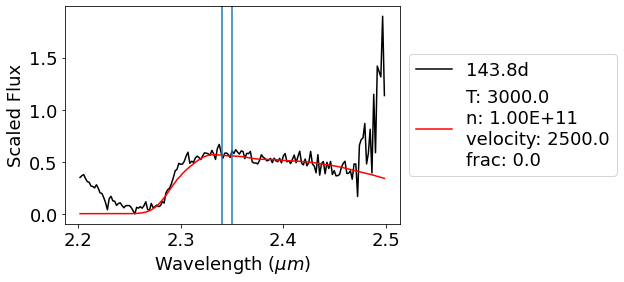

0.6525126055373685


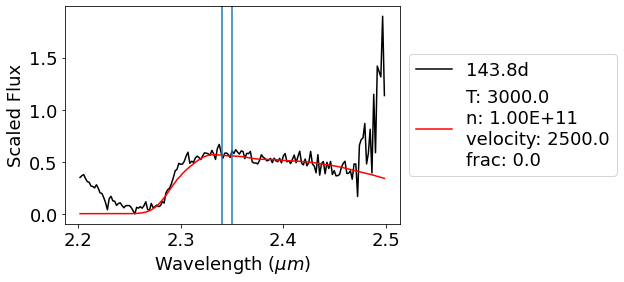

0.6528616409900697


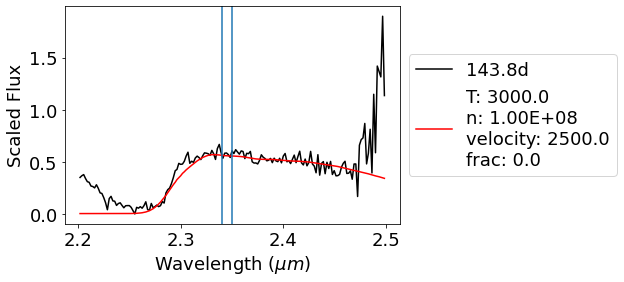

0.6528616409900697


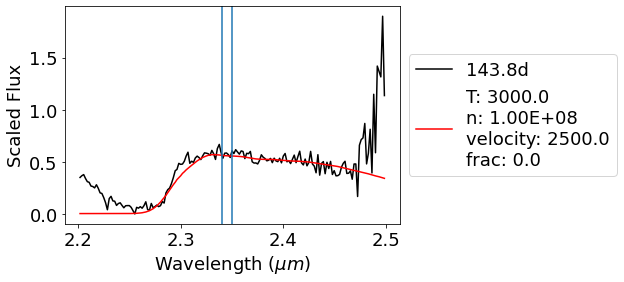

0.6775543178327661


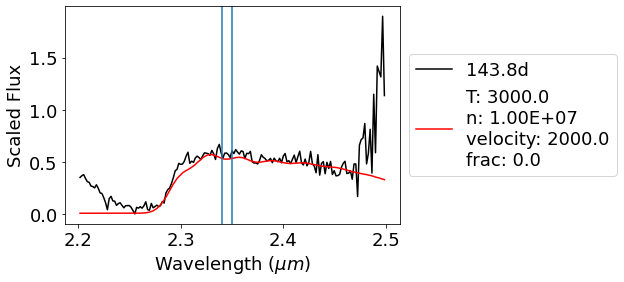

0.6775543178327661


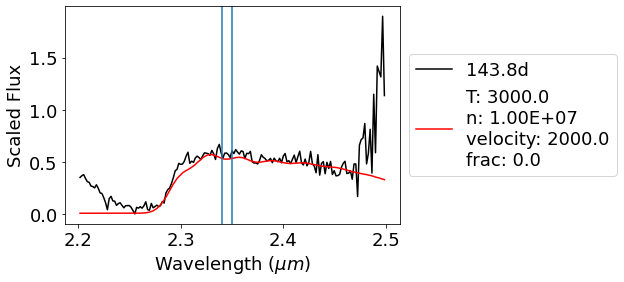

0.6914837124490614


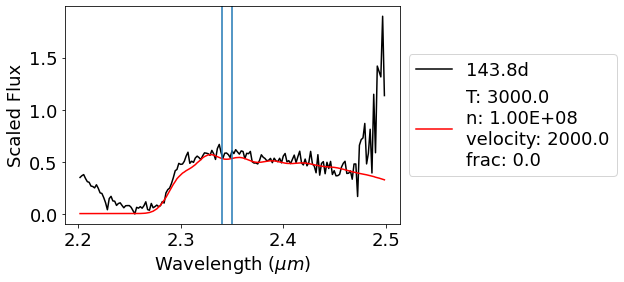

0.6914837124490614


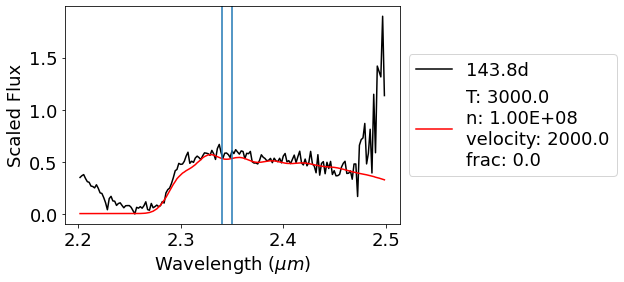

0.6915259071641892


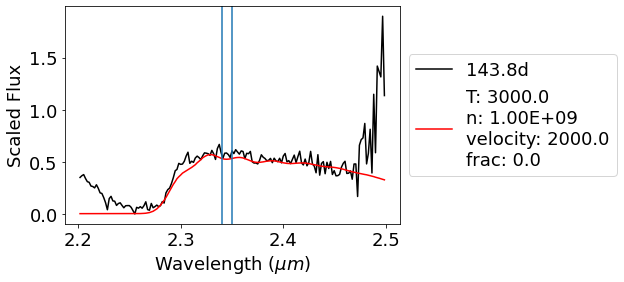

0.6915259071641892


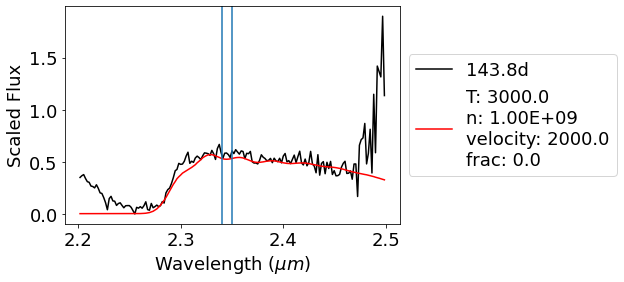

0.6950952820910546


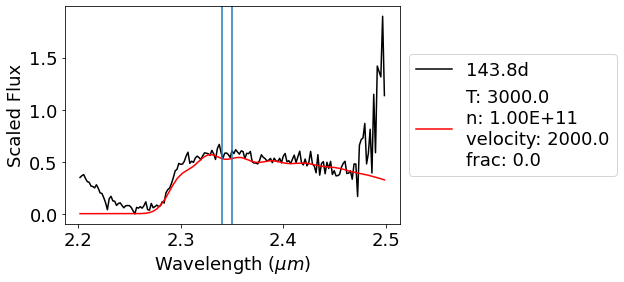

0.6950952820910546


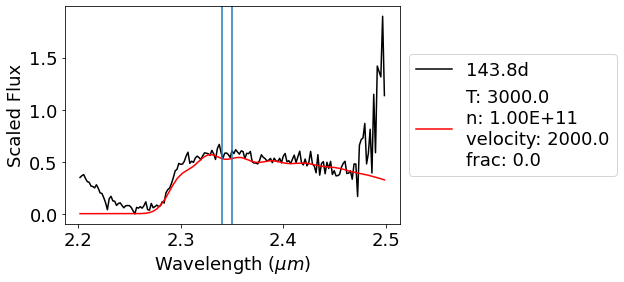

0.7378907407492318


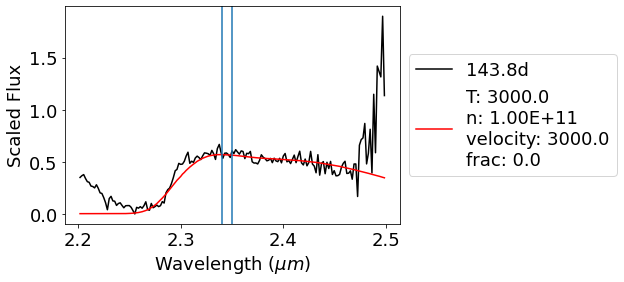

0.7378907407492318


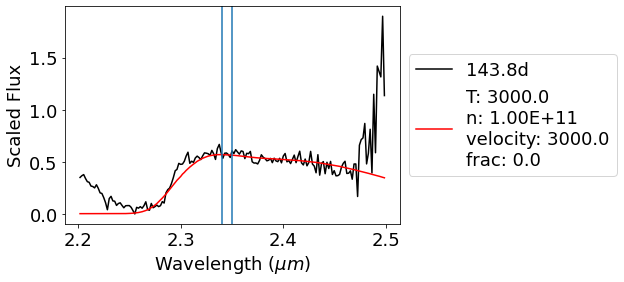

0.7385700041799986


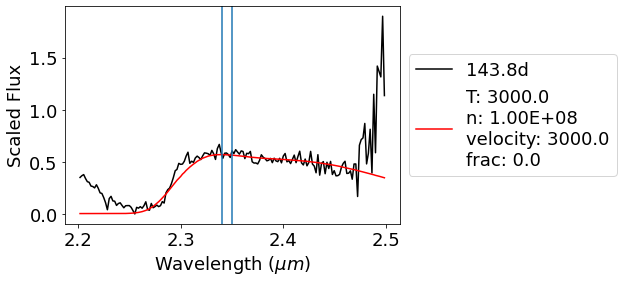

0.7385700041799986


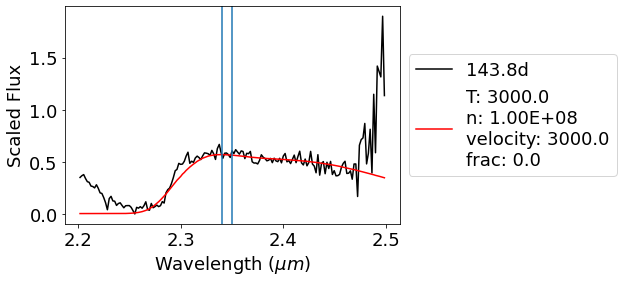

0.739162144910158


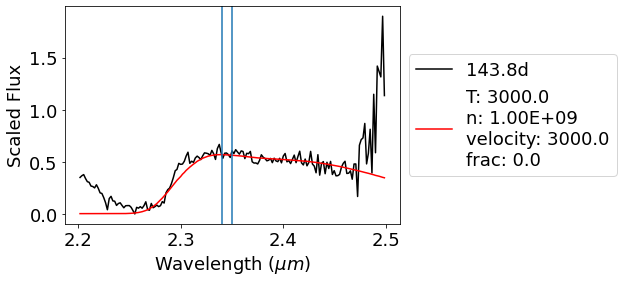

0.739162144910158


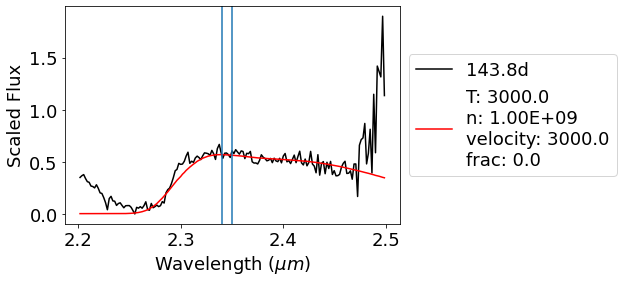

0.7425166489408461


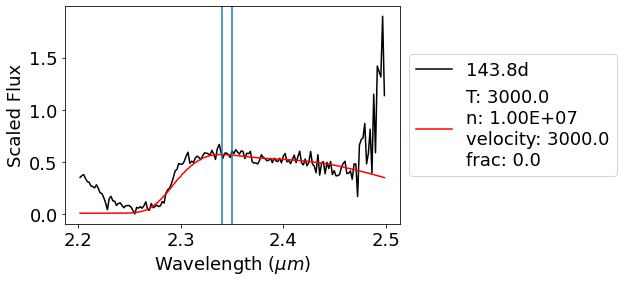

0.7425166489408461


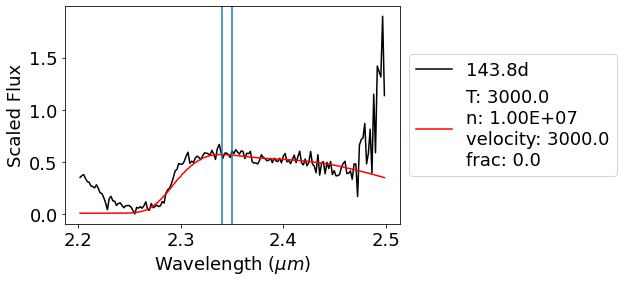

0.8396458347867956


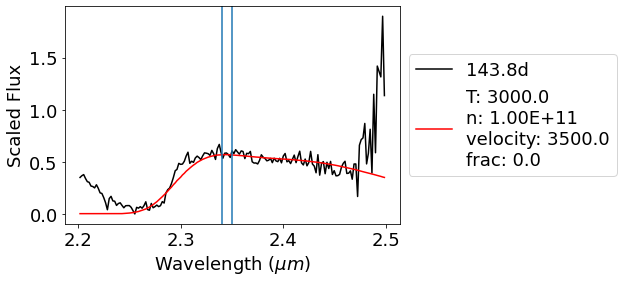

In [8]:
# this just supresses all the warnings that numpy and python like to throw
import warnings
warnings.filterwarnings("ignore")

def get_model_new(path,temp,n,velocity,mole_frac,molecule):
    modeldf = pd.read_csv(co_path+'/models_csv/'+
                          molecule+'_'+str(velocity)+'_'+str(mole_frac)+'.csv')

    n = str(format(n, "10.2E")).strip()
    temp = str(format(temp, ".2f")).strip()

    return [modeldf['wl'].values, modeldf[n+'/'+temp].values]

# loop over models
chisq, fArr, fileArr, params = [], [], [], []
for i in range(len(df)):
    if i%100 == 0 and i != 0: 
        print(str(round(i/len(df)*100,1))+'% done.')
        
    # get model from csv file
    wav, opac = get_model.get_csv(co_path+'/models_csv/',df.temperature.values[i],
                                  df.n.values[i],df.velocity.values[i],
                                  df.mole_frac.values[i],df.molecule.values[i])
    wav = wav/1e4
    
    # trim model
    w = np.where(wav >= 2.2)
    wav, opac = np.array(wav[w]), np.array(opac[w])
    
    # model scaling
    w = np.argmin(abs(wav-upper))
    v = np.argmin(abs(wav-lower))
    q = [(spec['lambda'] >= 2.20) & (spec['lambda'] <= 2.25)][0]
    integ = np.min(spec['flux'][q]) + np.trapz(opac[w:v],wav[w:v])
    opac = opac + integ
    interpF = np.interp(spec['lambda'],wav,opac) # interpolating to same x
    # scaling the model to match the data since the amount of CO is a free parameter
    w = [(spec['lambda'] >= 2.34)&(spec['lambda'] <= 2.35)][0]
    interpF = interpF*np.median(spec['flux'][w])/np.max(interpF)
    
    if plot:
        plt.plot(spec['lambda'],spec['flux'],color='black')
        plt.plot(spec['lambda'],interpF,color='red')
        plt.show()
        
    w = [(spec['lambda'] >= 2.28) & (spec['lambda'] <= 2.46)][0]
    chisq.append(stats.chisquare(interpF[w],spec['flux'].values[w])[0])
    fArr.append(interpF)
    fileArr.append(i)
    params.append([df.temperature.values[i],df.n.values[i],df.velocity.values[i],df.mole_frac.values[i]])
    
w = np.argsort(chisq)
chisq, fArr, fileArr, params = np.array(chisq)[w], np.array(fArr)[w], np.array(fileArr)[w], np.array(params)[w]

# plot best XX models for each spectrum
matplotlib.rcParams.update({'font.size': 18})
for i in range(25):
    label = r'T: '+str(params[i][0])+'\n'+'n: '+format(params[i][1],".2E")+'\n'+\
             'velocity: '+str(params[i][2])+'\n'+'frac: '+str(params[i][3])
    
    w = [(spec['lambda'].values < 2.5)]
    plt.plot(spec['lambda'].values[w],spec['flux'].values[w],color='black')
    plt.plot(spec['lambda'].values[w],fArr[i][w],color='red',label=label)
    
    q = [(spec['lambda'].values > 2.2) & (spec['lambda'].values < 2.5)]
    plt.xlabel(r'Wavelength ($\mu m$)')
    plt.ylabel('Scaled Flux')
    plt.legend(bbox_to_anchor=(1.0,0.5), loc="center left",labels=[str(specPhase)+'d',label])

    plt.show()